# Preparing Environment

We need to complete the following tasks before analyzing our data.

1.   Install and load necssary packages, such as Kaggle, transformers...
2.   Check the running environment.
3.   Log in the Kaggle API 
4.   Create a file path.
5.   Download datasets and then unzip them into csv format.
6.   Finally, check if our datasets are available or not.






In [ ]:
!pip install -q kaggle
!pip install -q datasets transformers[sentencepiece]
!pip install -q fastai

     |████████████████████████████████| 451 kB 31.3 MB/s 
     |████████████████████████████████| 5.5 MB 72.1 MB/s 
     |████████████████████████████████| 115 kB 76.8 MB/s 
     |████████████████████████████████| 182 kB 87.1 MB/s 
     |████████████████████████████████| 212 kB 89.0 MB/s 
     |████████████████████████████████| 127 kB 88.2 MB/s 
     |████████████████████████████████| 7.6 MB 65.2 MB/s 
     |████████████████████████████████| 1.3 MB 73.1 MB/s 


In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
creds = '{"username":"dongdonglu","key":"a15c9f012569587f3892a56683059d9a"}'

In [ ]:
from fastai.imports import *

In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [ ]:
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()

In [ ]:
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)

cred_path.chmod(0o600)

In [ ]:
path = Path('us-patent-phrase-to-phrase-matching')

In [ ]:
path.exists()

False

In [ ]:
if not iskaggle and not path.exists():
  import zipfile, kaggle
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 682k/682k [00:01<00:00, 568kB/s]

In [ ]:
ls {path}

sample_submission.csv  test.csv  train.csv


# EDA

We first load our dataset to see what it looks like.

In [ ]:
import pandas as pd

df = pd.read_csv(path/'train.csv')
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


Our dataset has 36473 rows, 733 unique anchors, 106 contexts, and 29340 targets. Certain anchors appears very often, for instance the  "component composite coating" appears 152 times.


In [ ]:
df.describe(include='object')
# every object is respect to id, anchor, target and context.

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


Then we went futher to check if the scores, context are balanced or not. It seems that the scores are balanced, but the context is little bit skewed toward lower scores.

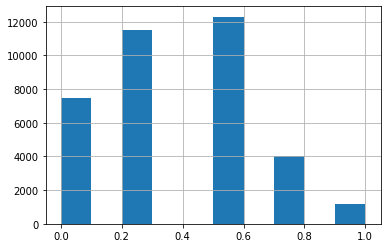

In [ ]:
df.score.hist()

The most frequently appearing context is "B" and the least frequently appearing context is "D". The sub-context are even more unbalanced, this might be due to the fact that more patents are granted in certain areas than than others.

In [ ]:
df['section'] = df.context.str[0] # get the initial letter for the context
df.section.value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: section, dtype: int64

In [ ]:
df.context.value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

Lastly we check what the instances with the highest and lowest score look like. Notice that "abatement" has similarity score 1 with "abating" in context "F", however it only has similarity score 0 with "rent abatement" in context A. This shows that the context is very important in determining the similarity between two words, rather than the simple word-spellings of phrases.

In [ ]:
df[df['score'] == 1]

,id,anchor,target,context,score,section
28,473137168ebf7484,abatement,abating,F24,1.0,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,B
...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,B


In [ ]:
df[df['score'] == 0]

,id,anchor,target,context,score,section
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.0,A
14,9001756895ec8ca1,abatement,pollution certificate,A47,0.0,A
15,cc96541d4987b399,abatement,rent abatement,A47,0.0,A
18,1222e36d9a94c2a4,abatement,stone abutments,A47,0.0,A
19,a8c9e9f37d4d836a,abatement,tax abatement,A47,0.0,A
...,...,...,...,...,...,...
36447,c7e11e374c52eec4,wood article,article spinner,B44,0.0,B
36448,c93eebfb43880214,wood article,article spinning,B44,0.0,B
36449,c997d1dc4fbcd02b,wood article,article tracking system,B44,0.0,B
36457,1d5bb300f80bc6db,wood article,plastic articles,B44,0.0,B


# Data Preprocessing

In [ ]:
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, AutoTokenizer

Here we provide a list of models, which will use in the following evaluations. Why do I pick those models? The answer is pretty straight, because I see other people are getting good results on Kaggle by using these models.

In [ ]:
model_dbt = 'microsoft/deberta-v3-small' 
model_bfp = 'anferico/bert-for-patents'

Write a function to automate the processing of getting the tokenizer corresponding to the model.

In [ ]:
def tokz(model):
  return AutoTokenizer.from_pretrained(model)

To conveniently convert the problem into a classification problem, we need to merge all the information for each row into a long string. The easiest way to do this is concatenate all the column values with the tokenizer's seperation token [SEP]. There are most sophiscated strategies such as convert the context into their English descriptions and then concatenate which has been proved helpful by others. But for simplicity we will only go with the simpliest method here.

In [ ]:
sep = tokz(model_dbt).sep_token
sep # same with bert for patent

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


'[SEP]'

In [ ]:
df['inputs'] = df.context + sep + df.anchor + sep + df.target 

In [ ]:
df.inputs
# dataframe can pull out the feature as .input

0        A47[SEP]abatement[SEP]abatement of pollution
1                A47[SEP]abatement[SEP]act of abating
2               A47[SEP]abatement[SEP]active catalyst
3           A47[SEP]abatement[SEP]eliminating process
4                 A47[SEP]abatement[SEP]forest region
                             ...                     
36468         B44[SEP]wood article[SEP]wooden article
36469             B44[SEP]wood article[SEP]wooden box
36470          B44[SEP]wood article[SEP]wooden handle
36471        B44[SEP]wood article[SEP]wooden material
36472       B44[SEP]wood article[SEP]wooden substrate
Name: inputs, Length: 36473, dtype: object

In [ ]:
# eval_df = pd.read_csv(path/'test.csv') # no score provided
# eval_df['inputs'] = eval_df.context + sep + eval_df.anchor + sep + eval_df.target 

In [ ]:
# eval_df.describe()

In [ ]:
# eval_df.describe(include='object')

In [ ]:
ds = Dataset.from_pandas(df).rename_column('score', 'label')
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'label', 'section', 'inputs'],
    num_rows: 36473
})

In [ ]:
# tokz_dbt = tokz(model_dbt)
# tokz_bfp = tokz(model_bfp)

In [ ]:
# def get_eval_ds(model):
#   tokenizer = tokz(model)
#   def tok_func(x):
#     return tokenizer(x['inputs'])
#   return Dataset.from_pandas(eval_df).map(tok_func, batched=True)

# get_eval_ds(model_dbt) # check if it work

To save memory, we create a list of columns to be removed (they will not be taken as inputs for the model).

In [ ]:
rm_columns = 'anchor', 'target', 'context', 'id', 'section', 'inputs'

## Creating Splits

According to a Kaggle post, the private test anchors do not overlap with the training set, therefore we should also apply the same practice for our validation and test sets. We first get all the unique anchors, shuffle them and then create indexs for train, validation, and test sets.

In [ ]:
anchors = df.anchor.unique()
len(anchors)

733

In [ ]:
np.random.seed(1)
np.random.shuffle(anchors)
anchors[:5] # see 5 anchors

array(['running tally', 'fire cartridges', 'cooled reaction', 'mayenite',
       'produce by pump'], dtype=object)

Manually set the first 10 anchors as test anchors. The rest 25% (183) of anchors as validation anchors, and all the others (540) as training anchors.

In [ ]:
val_prop =0.25
val_sz = int(len(anchors)*val_prop)

test_anchors = anchors[:10]
val_anchors = anchors[10:val_sz]
train_anchors = anchors[val_sz:]

Next, we create the index lists for train, validation and test sets.

In [ ]:
# create test indexes
test_idxs = [i for i in range(len(df)) if df.anchor[i] in test_anchors]
test_idxs = np.array(test_idxs)

# create validation indexes
val_idxs = [i for i in range(len(df)) if df.anchor[i] in val_anchors]
val_idxs = np.array(val_idxs)

# create training indexes
trn_idxs = [i for i in range(len(df)) if df.anchor[i] not in val_anchors]
trn_idxs = np.array(trn_idxs)

Create a function to prepare the dataset for the model.

In [ ]:
def get_dds(df, model):
  ds = Dataset.from_pandas(df).rename_column('score', 'label')
  tokenizer = tokz(model)
  def tokz_map(x):
    return tokenizer(x['inputs'])
  tok_ds = ds.map(tokz_map, batched=True, remove_columns=rm_columns)
  return DatasetDict({'train':tok_ds.select(trn_idxs),
                      'eval':tok_ds.select(val_idxs), 
                      'test': tok_ds.select(test_idxs)})

Then we create a dataset for test purpose and evaluate the difference between this random split of train and test using their mean scores. It turns out that the difference is negligible.

In [ ]:
dds_dbt = get_dds(df, model_dbt)

from numpy import mean
mean(dds_dbt['train']['label']), mean(dds_dbt['eval']['label'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ba/s]

(0.36164796156190615, 0.36340866728797766)

# Initiate models

Before we initiate our models, we need to define a metric. According to the Kaggle competition's webpage, "submissions are evaluated on the Pearson correlation coefficient between the predicted and actual similarity scores." So we define Pearson correlation score as the evaluation metric.

In [ ]:
import numpy as np
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

Then we create learning parameters that would work well in Colab in experience.

In [ ]:
bs = 128
epochs = 4
wd = 0.01
lr = 8e-5

In [ ]:
from transformers import TrainingArguments, Trainer

We also need two functions to accerlerate the creations of datasets, trainers.

In [ ]:
def get_model(model):
  return AutoModelForSequenceClassification.from_pretrained(model, num_labels=1)

In [ ]:
def get_trainer(dds, model):
  model_trainer = get_model(model) 
  args = TrainingArguments('outputs', 
                          learning_rate=lr,
                          warmup_ratio=0.1,
                          lr_scheduler_type='cosine',
                          fp16=True,
                          evaluation_strategy='epoch',
                          per_device_train_batch_size=bs,
                          per_device_eval_batch_size=bs*2,
                          num_train_epochs=epochs,
                          weight_decay=wd,
                          report_to='none')
  return Trainer(model_trainer, args, train_dataset=dds['train'], 
                 eval_dataset=dds['eval'], 
                 tokenizer=tokz(model), 
                 compute_metrics=corr)

## DeBERTa

According to the [original paper](https://arxiv.org/abs/2006.03654) "DeBERTa (Decoding-enhanced BERT with disentangled attention) improves the BERT and RoBERTa models using two novel techniques. The first is the disentangled attention mechanism, where each word is represented using two vectors that encode its content and position. Second, an enhanced mask decoder is used to replace the output softmax layer to predict the masked tokens for model pretraining. We show that these two techniques significantly improve the efficiency of model pretraining and performance of downstream tasks. Compared to RoBERTa-Large, a DeBERTa model trained on half of the training data performs consistently better on a wide range of NLP tasks, achieving improvements on MNLI by +0.9% (90.2% vs. 91.1%), on SQuAD v2.0 by +2.3% (88.4% vs. 90.7%) and RACE by +3.6% (83.2% vs. 86.8%)".

First we initiate dataset and trainer for DeBERTa, then we start the training process.

In [ ]:
dds_dbt = get_dds(df, model_dbt);
trainer_dbt = get_trainer(dds_dbt, model_dbt);
trainer_dbt.train()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.9/dist-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.028168,0.773382
2,No log,0.027317,0.785380
3,0.037600,0.026905,0.789747
4,0.037600,0.026486,0.790443


***** Running Evaluation *****
  Num examples = 8584
  Batch size = 256
***** Running Evaluation *****
  Num examples = 8584
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 8584
  Batch size = 256
***** Running Evaluation *****
  Num examples = 8584
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=872, training_loss=0.027323976569219467, metrics={'train_runtime': 318.6939, 'train_samples_per_second': 350.041, 'train_steps_per_second': 2.736, 'total_flos': 476860846159170.0, 'train_loss': 0.027323976569219467, 'epoch': 4.0})

In [ ]:
ds_test_dbt = dds_dbt['test']
ds_test_dbt

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 395
})

In [ ]:
def get_test_predictions(ds, trainer):
    preds= trainer.predict(ds)
    preds_values = preds.predictions
    preds_values_clipped = np.clip(preds_values, 0, 1)
    return preds_values_clipped

get_test_predictions(ds_test_dbt, trainer_dbt)

***** Running Prediction *****
  Num examples = 395
  Batch size = 256


array([0.        , 0.        , 0.55322266, 0.        , 0.6064453 ,
       0.016922  , 0.20275879, 0.6894531 , 0.02111816, 0.23876953,
       0.29052734, 0.6669922 , 0.        , 0.30273438, 0.42285156,
       0.36035156, 0.3190918 , 0.19482422, 0.36889648, 0.4428711 ,
       0.24829102, 0.5732422 , 0.31445312, 0.4650879 , 0.5463867 ,
       0.1595459 , 0.5083008 , 0.21374512, 0.32641602, 0.64746094,
       0.        , 0.7138672 , 0.6269531 , 0.        , 0.        ,
       0.6411133 , 0.42138672, 0.2927246 , 0.46264648, 0.03283691,
       0.2133789 , 0.01885986, 0.4482422 , 0.55371094, 0.5083008 ,
       0.53759766, 0.49438477, 0.61816406, 0.26293945, 0.31689453,
       0.30029297, 0.7138672 , 0.69970703, 0.01617432, 0.7426758 ,
       0.        , 0.        , 0.        , 0.4868164 , 0.3046875 ,
       0.4645996 , 0.3178711 , 0.4675293 , 0.        , 0.3022461 ,
       0.6088867 , 0.68408203, 0.2541504 , 0.0559082 , 0.52246094,
       0.        , 0.53564453, 0.        , 0.57714844, 0.25854

### Error Analysis

We have trained our first model on the training dataset using DeBERTa model. Now we can use this trained model to check where our highest losses come from. Potentially we can find the mislabelled data in the original datasets or get insights on how we can improve on our model. Let's first create predictions on the training dataset.

In [ ]:
df = dds_dbt['train']
preds = get_test_predictions(df, trainer_dbt)

***** Running Prediction *****
  Num examples = 27889
  Batch size = 256


Then we add the predictions into our dataset, convert it into pandas format, calculate and save the losses. We also create temproray pandas df naming ds_train to better play with the data later.

In [ ]:
df = df.add_column('preds', preds)
df.set_format('pandas')
df_loss = abs(df['label'] - df['preds'])
df = df.add_column('loss', df_loss)

ds_train = df[:]
ds_train

Flattening the indices:   0%|          | 0/28 [00:00<?, ?ba/s]

,label,input_ids,token_type_ids,attention_mask,preds,loss
0,0.50,"[1, 736, 3304, 2, 14478, 1022, 2, 14478, 1022, 514, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.586426,0.086426
1,0.25,"[1, 736, 3304, 2, 14478, 1022, 2, 4389, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1]",0.277588,0.027588
2,0.25,"[1, 736, 3304, 2, 14478, 1022, 2, 2100, 1022, 1569, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.368896,0.118896
3,0.25,"[1, 736, 3304, 2, 14478, 1022, 2, 1706, 8363, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.268555,0.018555
4,0.25,"[1, 736, 3304, 2, 14478, 1022, 2, 1706, 1569, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.337158,0.087158
...,...,...,...,...,...,...
27884,1.00,"[1, 736, 5153, 2, 1847, 1030, 2, 4164, 1030, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.000000,0.000000
27885,0.50,"[1, 736, 5153, 2, 1847, 1030, 2, 4164, 1352, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.576660,0.076660
27886,0.50,"[1, 736, 5153, 2, 1847, 1030, 2, 4164, 1997, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.577148,0.077148
27887,0.75,"[1, 736, 5153, 2, 1847, 1030, 2, 4164, 1146, 2]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.808105,0.058105


Here, we sort the losses and save only 4 columns from the training dataset. To see the result, we also need to convert input_ids back to tokens.

In [ ]:
ds_train = ds_train.sort_values("loss", ascending=False)[['input_ids', 'label', 'preds', 'loss']]

tokz_dbt = tokz(model_dbt)
ds_train['inputs'] = ds_train['input_ids'].map(lambda x: tokz_dbt.convert_tokens_to_string(tokz_dbt.convert_ids_to_tokens(x)))

loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att

Now we can eyeball some big losses come from mis-labels or controvosial labels. Just use our common sense, microchambers and microvessels have some similarity with each other, however they are labled with a score 0. Same reasoning applys to pictorial image and pictorial representation. 

On the other hand, we do find certain weakness of our model. For instance, Channel vectors are type of vectors, while channels of vectors are type of channels. Our model cannot distinguish this basic fact...To compensate this weakness, we might need to add an additional function to handle this kind of special situations.

In [ ]:
ds_train[['inputs', 'label', 'preds', 'loss']][:10]

,inputs,label,preds,loss
20528,[CLS] B21[SEP] punch face[SEP] face punch[SEP],0.75,0.000000,0.750000
18712,[CLS] G09[SEP] pictorial image[SEP] pictorial representation[SEP],0.00,0.710449,0.710449
3202,[CLS] F03[SEP] catching surface[SEP] catching nose[SEP],0.75,0.204102,0.545898
25267,[CLS] C07[SEP] therapeutic immune[SEP] therapeutic immune therapeutic[SEP],0.25,0.795410,0.545410
7881,[CLS] G01[SEP] ecn[SEP] networking system[SEP],0.00,0.530273,0.530273
3624,[CLS] H04[SEP] channel vectors[SEP] channels of vectors[SEP],0.00,0.528809,0.528809
12831,[CLS] G01[SEP] inner fluid conduit[SEP] inner fluid conduit sufficient[SEP],0.00,0.522461,0.522461
16279,[CLS] G01[SEP] noncollinear[SEP] non collinear lines[SEP],0.00,0.513672,0.513672
3619,[CLS] H04[SEP] channel vectors[SEP] channel of vectors[SEP],0.00,0.504883,0.504883
19798,[CLS] G01[SEP] previously captured image[SEP] previously reference image[SEP],0.00,0.503906,0.503906


Since we are supposed to classify the similaries into 5 categories (0.0, 0.25, 0.50, 0.75, 1.0). Let's plot a confusion matrix to see if there is any significant patterns among the mis-labellings. To do this, let's first write a function to round the predictions into its near quarter.

In [ ]:
def round_to_quarter(x):
  x_times4 = 4 * x
  x_time4_rounded = round(x_times4)
  x_rtq = x_time4_rounded / 4
  return x_rtq

ds_train['y_preds'] = ds_train['preds'].map(lambda x: round_to_quarter(x))
ds_train

,input_ids,label,preds,loss,inputs,y_preds
20528,"[1, 736, 2917, 2, 8460, 812, 2, 812, 8460, 2]",0.75,0.000000,0.750000,[CLS] B21[SEP] punch face[SEP] face punch[SEP],0.00
18712,"[1, 1098, 4505, 2, 38596, 1115, 2, 38596, 5190, 2]",0.00,0.710449,0.710449,[CLS] G09[SEP] pictorial image[SEP] pictorial representation[SEP],0.75
3202,"[1, 1107, 3984, 2, 8129, 1694, 2, 8129, 4752, 2]",0.75,0.204102,0.545898,[CLS] F03[SEP] catching surface[SEP] catching nose[SEP],0.25
25267,"[1, 716, 4649, 2, 8068, 5476, 2, 8068, 5476, 8068, 2]",0.25,0.795410,0.545410,[CLS] C07[SEP] therapeutic immune[SEP] therapeutic immune therapeutic[SEP],0.75
7881,"[1, 1098, 3085, 2, 865, 26478, 2, 5523, 492, 2]",0.00,0.530273,0.530273,[CLS] G01[SEP] ecn[SEP] networking system[SEP],0.50
...,...,...,...,...,...,...
22471,"[1, 1107, 3085, 2, 6699, 3261, 2, 5542, 3261, 2]",0.00,0.000000,0.000000,[CLS] F01[SEP] seal teeth[SEP] artificial teeth[SEP],0.00
22470,"[1, 336, 8540, 2, 6782, 8410, 2, 2014, 4912, 2]",0.00,0.000000,0.000000,[CLS] A63[SEP] scratch coating[SEP] winter coat[SEP],0.00
13326,"[1, 1107, 5920, 2, 40006, 6005, 2, 1376, 24422, 6005, 2]",0.00,0.000000,0.000000,[CLS] F41[SEP] intruder detection[SEP] covid detection[SEP],0.00
2174,"[1, 1107, 4159, 2, 636, 62766, 2, 1191, 636, 514, 2]",0.00,0.000000,0.000000,[CLS] F02[SEP] based propellant[SEP] network based data[SEP],0.00


Then we can extract predictions and labels, and convert their values into strings so that they can be used as inputs for the confusion matrix (which only take strings are inputs).

In [ ]:
y_preds = ds_train['y_preds']
y_valid = ds_train['label']

y_preds = [str(y_pred) for y_pred in y_preds]
y_valid = list(map(str, y_valid))

y_preds[:5], y_valid[:5]

(['0.0', '0.75', '0.25', '0.75', '0.5'],
 ['0.75', '0.0', '0.75', '0.25', '0.0'])

After plotting the confusion matrix, we can see that most of the model's mistakes come from the middle values where the labelled similarity scores range from 0.25 to 0.75. This is plausible as even human disagree with each other on two similar phrases if they were somewhat similar. The model is doing a good job in non-similar (score 0.0) or very-similar (score 1.0) phrases.

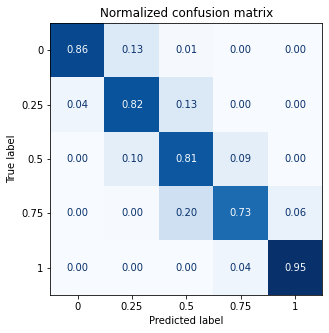

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = [0, 0.25, 0.5, 0.75, 1]


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    


plot_confusion_matrix(y_preds, y_valid, labels)

### Cross-validation

To see the a more realistic performance of the DeBERTa model on previously unseen data, we need to do cross-validations. First we load the dataset again (but shuffled). 

In [ ]:
df = pd.read_csv(path/'train.csv').sample(frac=1, random_state=1)
df['inputs'] = df.context + sep + df.anchor + sep + df.target 
df['section'] = df.context.str[0]
ds = Dataset.from_pandas(df).rename_column('score', 'label')

Then we create a 'get_tok_ds()' function to facilitate the generation of the tokenized dataset with respect to the model.

In [ ]:
# shuffle dataframe
def get_tok_ds(model):
    tokenizer = tokz(model)
    def tokz_map(x):
        return tokenizer(x['inputs'])
    tok_ds = ds.map(tokz_map, batched=True, remove_columns=rm_columns)
    return tok_ds

tok_ds_dbt = get_tok_ds(model_dbt);

loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att

  0%|          | 0/37 [00:00<?, ?ba/s]

The sklearn offers a train_test_split method which takes a random subset of the data. But this is a poor choice for many real-world problems, since real-world's datasets are often unbalanced w.r.t labels. To create a more balanced split, we use the StatifiedGroupKFold which create folds which preserve the percentage of samples for each class as much as possible given the constraint of non-overlapping groups between splits. For conveniency, we split the datasets into 4 folds.

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
n_folds = 4 
cv = StratifiedGroupKFold(n_splits=n_folds)

Then we create an array of indexs of rows, then create the folds w.r.t their scores and anchors.

In [ ]:
idxs = np.arange(len(df))
scores = (df.score*100).astype(int)
folds = list(cv.split(idxs, scores, df.anchor))

folds

In [ ]:
We also need another function to help us get the datasets after splits.

In [ ]:
def get_fold(folds, fold_num, model):
  train, eval = folds[fold_num]
  tok_ds = get_tok_ds(model)
  return DatasetDict({'train': tok_ds.select(train), 
                      'eval': tok_ds.select(eval)})

Lastly, we start the CV process and save the results into a list naming "cv_pearson_dbt". As we can the Pearson scores are around 0.79-0.80. So if we only use this model without ensembling, this will likely to be our final model performance. However, the highest score on private leadership board is around 0.89, with the assistance ensembling methods. We will also explore the use ensembling in the Combine Models section.

In [ ]:
cv_pearson_dbt = []

for i in range(n_folds):
    ds_cv = get_fold(folds, i, model_dbt)
    trainer_cv = get_trainer(ds_cv, model_dbt);
    trainer_cv.train()
    metrics = [o['eval_pearson'] 
           for o in trainer_cv.state.log_history
           if 'eval_pearson' in o]
    cv_pearson_dbt.append(metrics[-1])
    

loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att

  0%|          | 0/37 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input"

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.027792,0.785831
2,No log,0.026093,0.797625
3,0.032900,0.026578,0.798426
4,0.032900,0.026201,0.799873


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9127
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9127
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file 

  0%|          | 0/37 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input"

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.030275,0.759918
2,No log,0.027169,0.782810
3,0.031800,0.027362,0.788240
4,0.031800,0.027466,0.789437


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9105
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9105
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file 

  0%|          | 0/37 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input"

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.032727,0.770930
2,No log,0.027987,0.783872
3,0.031900,0.027574,0.789441
4,0.031900,0.027492,0.788000


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9122
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9122
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file 

  0%|          | 0/37 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input"

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.027587,0.781386
2,No log,0.025210,0.800806
3,0.032800,0.024475,0.802738
4,0.032800,0.025820,0.800310


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file 

In [ ]:
cv_valid_loss

[0.7998729789149337,
 0.7894370591127519,
 0.7879995197728323,
 0.8003102122402879]

## Bert For Patent

According to the blog post "How AI, and specifically BERT, helps the patent industry": Google trained a BERT (bidirectional encoder representation from transformers) model on over 100 million patent publications from the U.S. and other countries using open-source tooling. Google’s release of the BERT model (paper, blog post, and open-source code) in 2018 was an important breakthrough that leveraged transformers to outperform other leading state of the art models across major NLP benchmarks, including GLUE, MultiNLI, and SQuAD. Shortly after its release, the BERT framework and many additional transformer-based extensions gained widespread industry adoption across domains like search, chatbots, and translation.

We repeat the same process (as we did for DeBERTa):initate and train the model, then get its predictions on the test dataset.

In [ ]:
dds_bfp = get_dds(df, model_bfp)
trainer_bfp = get_trainer(dds_bfp, model_bfp)
trainer_bfp.train()

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329k [00:00<?, ?B/s]

  0%|          | 0/37 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

Epoch,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 8584
  Batch size = 256


ValueError: ignored

In [ ]:
df.columns

Index(['id', 'anchor', 'target', 'context', 'score', 'section', 'inputs'], dtype='object')

In [ ]:
ds_test_bfp = dds_bfp['test']
ds_test_bfp

In [ ]:
def get_test_predictions(ds, trainer):
    preds= trainer.predict(ds)
    preds_values = preds.predictions
    preds_values_clipped = np.clip(preds_values, 0, 1)
    return preds_values_clipped

%%capture --no-display
get_test_predictions(ds_test_bfp, trainer_dbt)

### Error Analysis

In [ ]:
df = dds['train']

In [ ]:
df = df.add_column('preds', preds)

In [ ]:
df.set_format('pandas')

In [ ]:
df_loss = abs(df['label'] - df['preds'])
df = df.add_column('loss', df_loss)

In [ ]:
df['loss']

In [ ]:
df

In [ ]:
# officially change the format to pandas df
ds_train = df[:]

In [ ]:
ds_train

In [ ]:
ds_train = ds_train.sort_values("loss", ascending=False)[['input_ids', 'label', 'preds', 'loss']]
ds_train

In [ ]:
ds_train['inputs'] = ds_train['input_ids'].map(lambda x: tokz.convert_tokens_to_string(tokz.convert_ids_to_tokens(x)))

In [ ]:
# eyeball some big losses come from mis-labels or controvosial labels
ds_train[['inputs', 'label', 'preds', 'loss']][:10]

In [ ]:
def round_to_quarter(x):
  x_times4 = 4 * x
  x_time4_rounded = round(x_times4)
  x_rtq = x_time4_rounded / 4
  return x_rtq

In [ ]:
round_to_quarter(0.37), round_to_quarter(0.375)

In [ ]:
ds_train['y_preds'] = ds_train['preds'].map(lambda x: round_to_quarter(x))
ds_train

In [ ]:
# extract predictions and labels
y_preds = ds_train['y_preds']
y_valid = ds_train['label']

In [ ]:
# convert the values into strings 
# so that they can be used as inputs for the confusion matrix
y_preds = [str(y_pred) for y_pred in y_preds]
y_valid = list(map(str, y_valid))

y_preds[:5], y_valid[:5]

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = [0, 0.25, 0.5, 0.75, 1]


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    


plot_confusion_matrix(y_preds, y_valid, labels)

# Combine Models

In [ ]:
models = [model_dbt, model_bfp]

trainers = [trainer_dbt, trainer_bfp]

predictions = []

for model, trainer in zip(models, trainers):
    test_ds_ems = get_dds(model)
    preds = get_predictions(test_ds_ems, trainer)
    predictions.append(preds_clipped)
    # take average here.


# Try Model Variations

## Change special tokens

### Use patent section letters as sep

In [ ]:
df.section

In [ ]:
df['sectok'] = '[' + df.section + ']'

In [ ]:
sectoks =  list(df.sectok.unique())
sectoks

In [ ]:
tokz.add_special_tokens({'additional_special_tokens': sectoks})

In [ ]:
df['inputs'] = df['sectok'] + sep + df['context'] + sep + df['anchor'].str.lower() + sep + df.target
df.inputs

In [ ]:
dds = get_dds(df)
dds

In [ ]:
model_patent_section = get_model()

In [ ]:
model_patent_section.resize_token_embeddings(len(tokz))

In [ ]:
trainer_patent_section =  get_trainer(dds, model=model_patent_section)
trainer_patent_section.train()